In [1]:
import sys
sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms

import torchvision
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.data.pipeline import build_augmentator
from visualDet3D.utils.timer import Timer
import matplotlib.pyplot as plt
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("../config/kitti_monoflex.py")
is_test_train = True

checkpoint_name = "MonoFlex_latest.pth"

CUDA available: True


In [2]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [3]:
cfg.data.augmentation.mirrorProb = 0
cfg.data.augmentation.distortProb = 0
cfg.batch_size=1
cfg.trainer.gpu=0
cfg.detector.head.test_cfg.score_thr=0.3
split_to_test='validation'

is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

dataset.transform = build_augmentator(cfg.data.test_augmentation)
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
detector.load_state_dict(state_dict, strict=False)
detector.eval()

# testing pipeline
#test_func = PIPELINE_DICT[cfg.trainer.test_func]

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth
Apply DLA Upsampling instead, feature_size=64


In [4]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

In [5]:
colors = [[0, 255, 255], [0, 0, 255], [255, 0, 0], [255, 120, 0],
          [255, 120, 120], [0, 120, 0], [120, 255, 255], [120, 0, 255]]
import time
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    image = collated_data[0]

    with torch.no_grad():
        image = collated_data[0]
        P2 = collated_data[1]
        
        torch.cuda.synchronize()
        start_time = time.time()
        scores, bbox, obj_names = detector([image.cuda().contiguous(), P2.cuda().contiguous()])
        torch.cuda.synchronize()
        end_time = time.time()
        print(end_time - start_time)
        

    if is_draw:
        img = image.squeeze().permute(1, 2, 0).numpy()
        rgb_image = denorm(img)
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        
        
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w, h ,l, alpha]
        #bbox_3d_state_3d = torch.cat([position, dims, alpha], dim=1)
        print(bbox_3d_state_3d[:, 0:3])
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        if len(scores) > 0:
            rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
          
        
        plt.imshow(rgb_image)
        
    return rgb_image, scores, bbox
    

In [6]:
index = 0

0.04949498176574707
tensor([[-1.2305,  0.8426,  8.1100],
        [ 1.0224,  0.8685, 14.6640],
        [ 8.6391,  0.9458, 20.4728],
        [ 3.8514,  0.9895,  6.0511],
        [ 6.5640,  0.6047, 30.9386],
        [ 9.6828,  0.7435, 40.2990],
        [17.8728,  0.6940, 49.1610],
        [19.9049,  0.1904, 69.4545]], device='cuda:0')


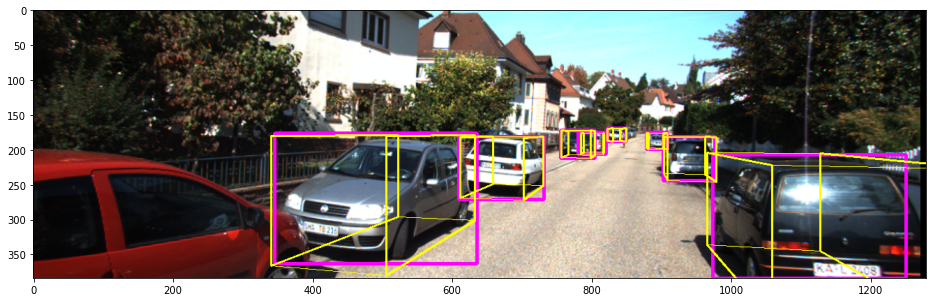

In [7]:
%matplotlib inline
index+=5
fig = plt.figure(figsize=(16,9))
_ = compute_once(index)
plt.show()